In [1]:
import control
import matplotlib.pyplot as plt
import numpy as np

import vishack
import kontrol

seis_data1 = vishack.data.diaggui.Diaggui("../data/quiet_20240222.xml")
seis_data2 = vishack.data.diaggui.Diaggui("../data/quiet_20230720.xml")
seis_data3 = vishack.data.diaggui.Diaggui("../data/lockloss_20240101.xml")
seis_data4 = vishack.data.diaggui.Diaggui("../data/lockloss_20240107.xml")
seis_data5 = vishack.data.diaggui.Diaggui("../data/lockloss_20240112.xml")

In [2]:
f, seis_x1 = seis_data1.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x2 = seis_data2.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x3 = seis_data3.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x4 = seis_data4.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x5 = seis_data5.psd("L1:ISI-GND_STS_ITMX_X_DQ")

_, gs13_x1 = seis_data1.psd("L1:ISI-ITMX_ST2_BLND_X_GS13_CUR_IN1_DQ")


# Calibrate to m
seis_x1 = seis_x1 * 1/(2*np.pi*f) * 1e-9  # Integrate and nm to m
seis_x2 = seis_x2 * 1/(2*np.pi*f) * 1e-9
seis_x3 = seis_x3 * 1/(2*np.pi*f) * 1e-9
seis_x4 = seis_x4 * 1/(2*np.pi*f) * 1e-9
seis_x5 = seis_x5 * 1/(2*np.pi*f) * 1e-9

s = control.tf("s")
wn = 1*2*np.pi
q = 1/np.sqrt(2)
gs13_cal = (s**2 + wn/q*s + wn**2) / (s**3)

gs13_x1 = gs13_x1 * abs(gs13_cal(1j*2*np.pi*f)) * 1e-9

In [3]:
h_sc = kontrol.load_transfer_function("../filters/CML_BB_SC.pkl")
h1 = kontrol.load_transfer_function("../filters/102mHzv2_disp.pkl")
h2 = kontrol.load_transfer_function("../filters/102mHzv2_inert.pkl")

# Undo calibration coupling in the filter
h_sc = h_sc * s  # undo integrator
h2 = h2/gs13_cal  # undo gs13 calibration filter

In [4]:
def noise_model(f, na, nb, a, b):
    noise = ((na/f**a)**2+(nb/f**b)**2)**.5
    return noise

n_seis_params2 = [1*10**-9.9, 0, 2.5, 0]
n_seis_params1 = [1*10**-9.15, 0, 2.5, 0]
n_seis_params4 = [1*10**-9.8, 0, 2.5, 0]

In [5]:
gs13_noise_data = [ 670, 6.32e-5, 2.138e-8, 1.958e-9, 1.892e-10, 1.732e-11,
                    7.262e-12, 3.887e-12, 2.449e-12, 1.462e-12, 9.725e-13, 
                    4.423e-13, 3.280e-13, 1.137e-13, 5.610e-14, 2.053e-14,
                    2e-15]   
gs13_freq_data = [1e-4, 0.01, 0.101, 0.201, 0.400, 0.792, 0.994, 1.258, 1.655, 2.588, 
                 3.954, 8.202, 10.710, 24.796, 46.087, 91.208, 1e3]

ade1_freq_data   = [.001,  .002,  .01,    .1,    .7,    100]
ade1_noise_data  = [ 5e-8, 9e-9, 2.5e-9, 5e-10, 2e-10, 2e-10]

n_gs13_params = [1*10**-11.125, 1*10**-11.375, 3.5, 1.15]
n_ade1_params = [1*10**-10.0625, 2e-10, 0.75, 0]

n_seis1 = lambda f: noise_model(f, *n_seis_params1)
n_seis2 = lambda f: noise_model(f, *n_seis_params2)
n_seis4 = lambda f: noise_model(f, *n_seis_params4)

n_gs13 = lambda f: noise_model(f, *n_gs13_params)
n_ade1 = lambda f: noise_model(f, *n_ade1_params)

In [6]:
xg1 = np.array(seis_x1)
xg1[f<0.09] = xg1[f>=0.09][0] 

xg2 = np.array(seis_x2)
xg2[f<0.08] = xg2[f>=0.08][0] 

xg4 = np.array(seis_x4)
xg4[f<0.03] = xg4[f>=0.03][0] 

In [7]:
n_seis_filtered1 = abs(h_sc(1j*2*np.pi*f)) * n_seis1(f)
n_seis_filtered2 = abs(h_sc(1j*2*np.pi*f)) * n_seis2(f)
n_seis_filtered4 = abs(h_sc(1j*2*np.pi*f)) * n_seis4(f)

xg_filtered1 = abs((1-h_sc)(1j*2*np.pi*f)) * xg1
xg_filtered2 = abs((1-h_sc)(1j*2*np.pi*f)) * xg2
xg_filtered4 = abs((1-h_sc)(1j*2*np.pi*f)) * xg4

n_sc1 = kontrol.core.math.quad_sum(n_seis_filtered1, xg_filtered1)
n_sc2 = kontrol.core.math.quad_sum(n_seis_filtered2, xg_filtered2)
n_sc4 = kontrol.core.math.quad_sum(n_seis_filtered4, xg_filtered4)

n_rel_sc1 = kontrol.core.math.quad_sum(n_ade1(f), n_sc1)
n_rel_sc2 = kontrol.core.math.quad_sum(n_ade1(f), n_sc2)
n_rel_sc4 = kontrol.core.math.quad_sum(n_ade1(f), n_sc4)

n_rel_filtered1 = abs(h1(1j*2*np.pi*f)) * n_rel_sc1
n_rel_filtered2 = abs(h1(1j*2*np.pi*f)) * n_rel_sc2
n_rel_filtered4 = abs(h1(1j*2*np.pi*f)) * n_rel_sc4

n_gs13_filtered1 = abs(h2(1j*2*np.pi*f)) * n_gs13(f)
n_gs13_filtered2 = abs(h2(1j*2*np.pi*f)) * n_gs13(f)
n_gs13_filtered4 = abs(h2(1j*2*np.pi*f)) * n_gs13(f)

n_super1 = kontrol.core.math.quad_sum(n_rel_filtered1, n_gs13_filtered1)
n_super2 = kontrol.core.math.quad_sum(n_rel_filtered2, n_gs13_filtered2)
n_super4 = kontrol.core.math.quad_sum(n_rel_filtered4, n_gs13_filtered4)

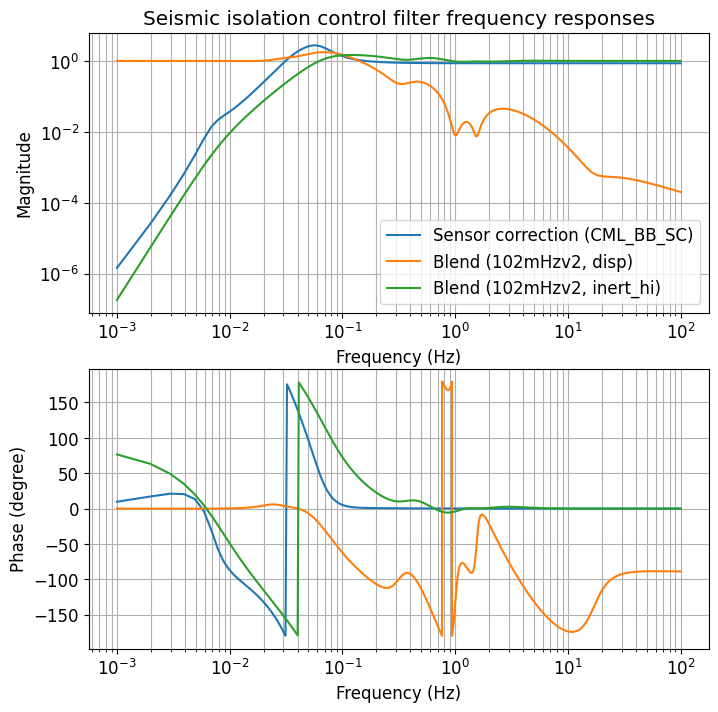

In [8]:
plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 12})
plt.subplot(211)
plt.title("Seismic isolation control filter frequency responses")
plt.loglog(f, abs(h_sc(1j*2*np.pi*f)), label="Sensor correction (CML_BB_SC)")
plt.loglog(f, abs(h1(1j*2*np.pi*f)), label="Blend (102mHzv2, disp)")
plt.loglog(f, abs(h2(1j*2*np.pi*f)), label="Blend (102mHzv2, inert_hi)")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend(loc=0)
plt.grid(which="both")

plt.subplot(212)
plt.semilogx(f, np.angle(h_sc(1j*2*np.pi*f), deg=True))
plt.semilogx(f, np.angle(h1(1j*2*np.pi*f), deg=True), label="Blend (102mHzv2, disp)")
plt.semilogx(f, np.angle(h2(1j*2*np.pi*f), deg=True), label="Blend (102mHzv2, inert_hi)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (degree)")
# plt.legend(loc=0)
plt.grid(which="both")

NameError: name 'n_super_hinf1' is not defined

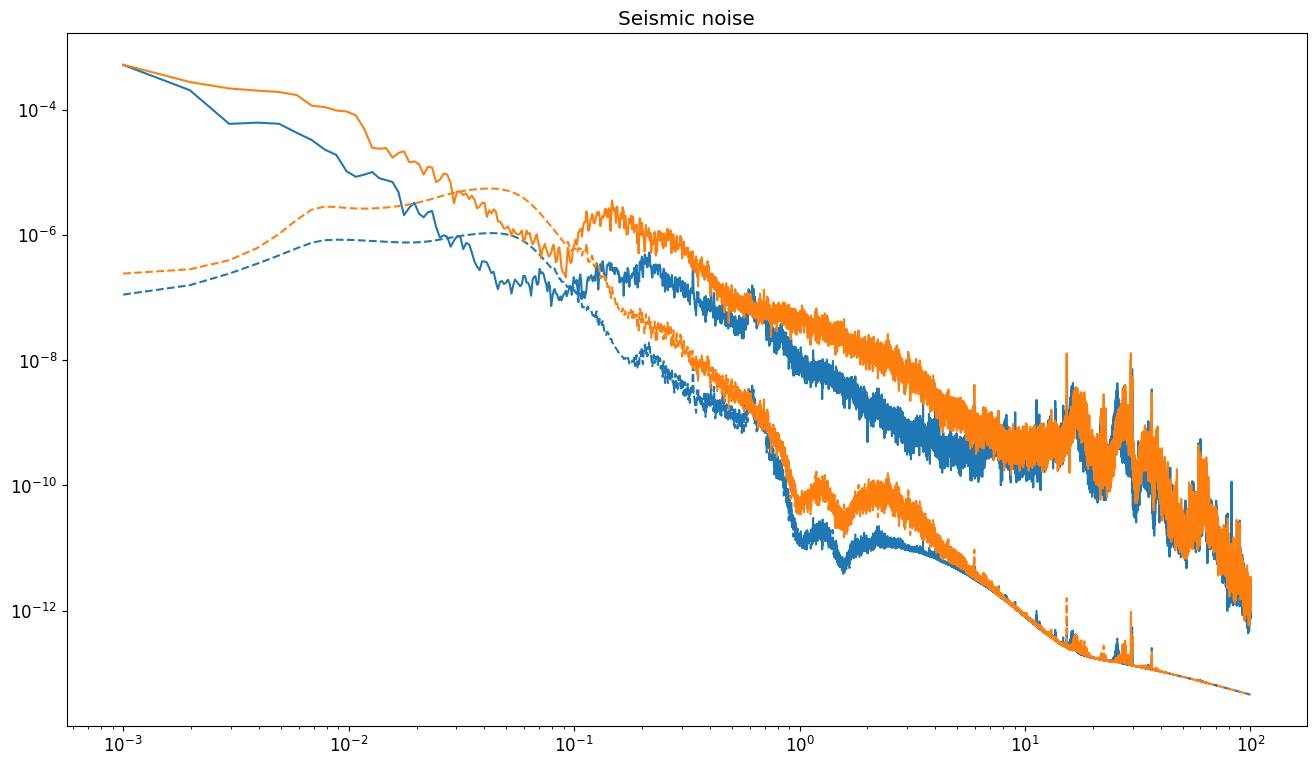

In [11]:
plt.figure(figsize=(16, 9))
plt.title("Seismic noise")
plt.rcParams.update({'font.size': 12})

plt.loglog(f, seis_x2, label="ITMX X 2023-07-20 (Observing)")
# plt.loglog(f, noise_model(f, *n_seis_params2), "C0--")
# plt.loglog(f, xg2)
# plt.loglog(f, n_sc2, "C0-.")
# plt.loglog(f, n_rel_sc2, "C0:")
plt.loglog(f, n_super2, "C0--", label="HAM motion")
# plt.loglog(f, asd2, "C0:")
# plt.loglog(f, rms_disp2, "C0:")

plt.loglog(f, seis_x1, label="ITMX X 2024-02-22 (Quiet)")
# # plt.loglog(f, n_seis1(f), "C1--")
# plt.loglog(f, xg1)
# plt.loglog(f, n_sc1, "C1-.")
# plt.loglog(f, n_rel_sc1, "C1:")
plt.loglog(f, n_super1, "C1--")
plt.loglog(f_, n_super_hinf1, "C1:")
# plt.loglog(f, asd1, "C1:")
# plt.loglog(f, rms_disp1, "C1:")

# plt.loglog(f, seis_x3, label="ITMX X 2024-01-01 (Earthquake)")

plt.loglog(f, seis_x4, label="ITMX X 2023-01-07 (Microseism)")
# # plt.loglog(f, noise_model(f, *n_seis_params4), "C2--")
# plt.loglog(f, xg4)
# plt.loglog(f, n_sc4, "C2-.")
# plt.loglog(f, n_rel_sc4, "C2:")
plt.loglog(f, n_super4, "C2--")
plt.loglog(f_, n_super_hinf4, "C2:")

# plt.loglog(f, rms_disp4, "C2:")

# plt.loglog(f, seis_x5, label="ITMX X 2023-01-12 (?)")

# plt.loglog(ade1_freq_data, ade1_noise_data)
# plt.loglog(f, noise_model(f, *n_ade1_params), "C3--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")

In [258]:
# rms_disp1 = kontrol.spectral.asd2rms(f=f, asd=n_super1)
# rms_disp2 = kontrol.spectral.asd2rms(f=f, asd=n_super2)
# rms_disp4 = kontrol.spectral.asd2rms(f=f, asd=n_super4)

# rms_vel1 = kontrol.spectral.asd2rms(f=f, asd=n_super1*2*np.pi*f)
# rms_vel2 = kontrol.spectral.asd2rms(f=f, asd=n_super2*2*np.pi*f)
# rms_vel4 = kontrol.spectral.asd2rms(f=f, asd=n_super4*2*np.pi*f)

In [12]:
kontrol.spectral.asd2rms(f=f[(f>0.1)*(f<0.3)], asd=n_super4[(f>0.1)*(f<0.3)], return_series=False)

1.9233059978940832e-07

In [13]:
kontrol.spectral.asd2rms(f=f_[(f_>0.1)*(f_<0.3)], asd=n_super_hinf4[(f_>0.1)*(f_<0.3)], return_series=False)

NameError: name 'n_super_hinf4' is not defined

In [25]:
f_lower = 2e-3
f_upper = 10
f_ = np.logspace(-3, 2, 1024)
n_seis1_pad = n_seis1(f_)
n_seis1_pad[f_<f_lower] = n_seis1_pad[f_>=f_lower][0]
n_seis1_pad[f_>f_upper] = n_seis1_pad[f_<=f_upper][-1]

n_seis4_pad = n_seis4(f_)
n_seis4_pad[f_<f_lower] = n_seis4_pad[f_>=f_lower][0]
n_seis4_pad[f_>f_upper] = n_seis4_pad[f_<=f_upper][-1]

xg1_pad = xg1.copy()
xg1_pad[f>f_upper] = xg1[f<=f_upper][-1]

xg2_pad = xg2.copy()
xg2_pad[f>5] = xg2[f<=5][-1]

xg4_pad = xg4.copy()
xg4_pad[f>f_upper] = xg4[f<=f_upper][-1]

In [38]:
tf_xg1 = kontrol.load_transfer_function("tf_xg_20240222.pkl")
tf_xg4 = kontrol.load_transfer_function("tf_xg_20240107.pkl")
tf_n_seis1 = kontrol.load_transfer_function("tf_n_seis_20240222.pkl")

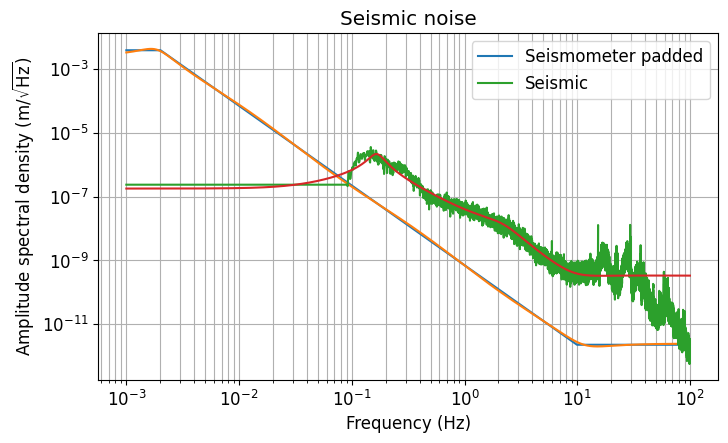

In [165]:
plt.figure(figsize=(8, 4.5))
plt.title("Seismic noise")
plt.rcParams.update({'font.size': 12})

# plt.loglog(f, n_seis1(f), label="seismometer")
plt.loglog(f_, n_seis1_pad, label="Seismometer padded")
plt.loglog(f_, abs(tf_n_seis1(1j*2*np.pi*f_)))
plt.loglog(f, xg1, label="Seismic")
plt.loglog(f, abs(tf_xg1(1j*2*np.pi*f)))

# plt.loglog(f, xg1_pad)
# plt.loglog(f, n_ade1(f), label="ADE1")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")

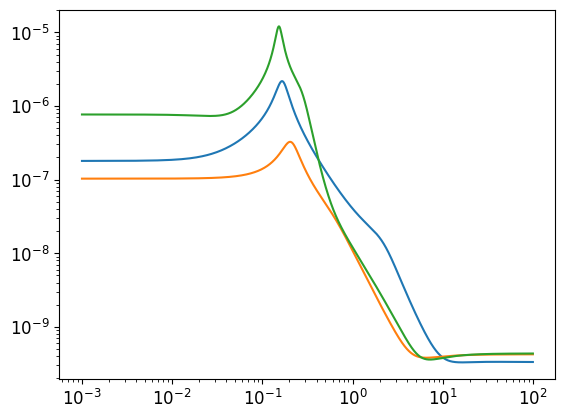

In [39]:
plt.loglog(f, abs(tf_xg1(1j*2*np.pi*f)))
plt.loglog(f, abs(tf_xg2(1j*2*np.pi*f)))
plt.loglog(f, abs(tf_xg4(1j*2*np.pi*f)))

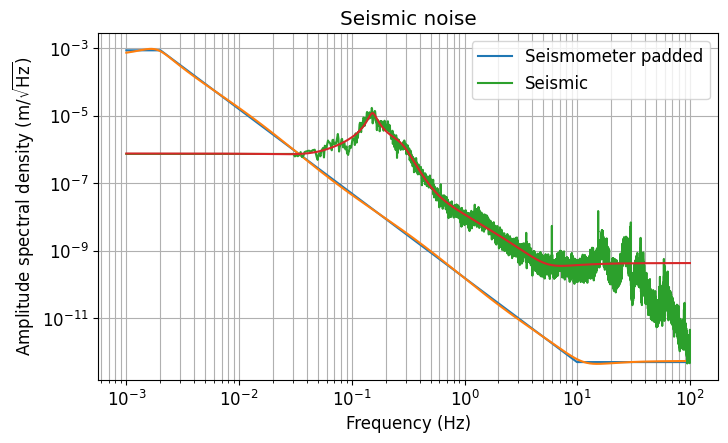

In [164]:
plt.figure(figsize=(8, 4.5))
plt.title("Seismic noise")
plt.rcParams.update({'font.size': 12})

# plt.loglog(f, n_seis1(f), label="seismometer")
plt.loglog(f_, n_seis4_pad, label="Seismometer padded")
plt.loglog(f_, abs(tf_n_seis4(1j*2*np.pi*f_)))
plt.loglog(f, xg4, label="Seismic")
plt.loglog(f, abs(tf_xg4(1j*2*np.pi*f)))

# plt.loglog(f, xg1_pad)
# plt.loglog(f, n_ade1(f), label="ADE1")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")

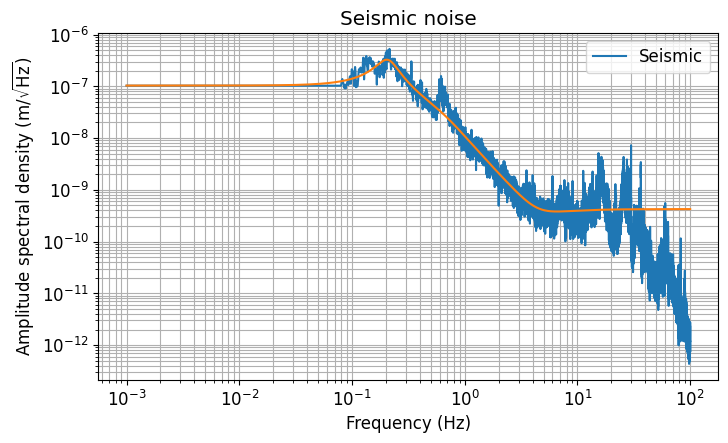

In [33]:
plt.figure(figsize=(8, 4.5))
plt.title("Seismic noise")
plt.rcParams.update({'font.size': 12})

# plt.loglog(f, n_seis1(f), label="seismometer")
# plt.loglog(f_, n_seis2_pad, label="Seismometer padded")
# plt.loglog(f_, abs(tf_n_seis2(1j*2*np.pi*f_)))
plt.loglog(f, xg2, label="Seismic")
plt.loglog(f, abs(tf_xg2(1j*2*np.pi*f)))

# plt.loglog(f, xg1_pad)
# plt.loglog(f, n_ade1(f), label="ADE1")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")

In [32]:
# tf_xg1 = kontrol.curvefit.spectrum_fit(f, xg1_pad, nzero=6, npole=6)
# tf_xg4 = kontrol.curvefit.spectrum_fit(f[f<10], xg4_pad[f<10], nzero=6, npole=6)
mask = (f<10)*((f<0.5)+(f>0.8))
tf_xg2 = kontrol.curvefit.spectrum_fit(f[mask], xg2_pad[mask], nzero=4, npole=4)

In [34]:
# tf_xg2.save("tf_xg_20230722.pkl")

In [121]:
# tf_n_seis1 = kontrol.curvefit.spectrum_fit(f_, n_seis1_pad, nzero=4, npole=4)
# tf_n_seis4 = kontrol.curvefit.spectrum_fit(f_, n_seis4_pad, nzero=4, npole=4)

In [123]:
# tf_xg1.save("tf_xg_20240222.pkl")
# tf_n_seis1.save("tf_n_seis_20240222.pkl")

# tf_xg4.save("tf_xg_20240107.pkl")
# tf_n_seis4.save("tf_n_seis_20240107.pkl")

In [166]:
comp = kontrol.ComplementaryFilter()
comp.noise1 = tf_xg1
comp.noise2 = tf_n_seis1
comp.weight1 = 1/tf_n_seis1
comp.weight2 = 1/tf_xg1
comp.h2synthesis()

h_trans_hinf1, h_sc_hinf1 = comp.hinfsynthesis()

In [266]:
comp = kontrol.ComplementaryFilter()
comp.noise1 = tf_xg4
comp.noise2 = tf_n_seis4
comp.weight1 = 1/tf_n_seis4
comp.weight2 = 1/tf_xg4
comp.h2synthesis()

h_trans_hinf4, h_sc_hinf4 = comp.hinfsynthesis()

In [273]:
comp = kontrol.ComplementaryFilter()
comp.noise1 = tf_xg4
comp.noise2 = 2*tf_n_seis4
comp.weight1 = 1/2/tf_n_seis4
comp.weight2 = 1/tf_xg4
comp.h2synthesis()

h_trans_hinf4_2, h_sc_hinf4_2 = comp.hinfsynthesis()

In [232]:
# h_sc_hinf1.save("h_sc_hinf_20240222.pkl")

In [267]:
# h_sc_hinf4.save("h_sc_hinf_20240107.pkl")

In [297]:
# h_sc_hinf4_2.save("h_sc_hinf_20240107_2.pkl")

In [231]:
# h_sc_prefilt = kontrol.TransferFunction(prefilt_sc)
# h_sc_prefilt.save("h_sc_prefilt.pkl")

In [15]:
f__ = np.logspace(-4, 1, 1024)

In [274]:
prefilt_sc = (s/(s+0.002*2*np.pi))**3

h_sc_hinf1_prefilt = h_sc_hinf1 * prefilt_sc
h_trans_hinf1_prefilt = 1-h_sc_hinf1_prefilt

h_sc_hinf4_prefilt = h_sc_hinf4 * prefilt_sc
h_trans_hinf4_prefilt = 1-h_sc_hinf4_prefilt

h_sc_hinf4_2_prefilt = h_sc_hinf4_2 * prefilt_sc
h_trans_hinf4_2_prefilt = 1-h_sc_hinf4_2_prefilt

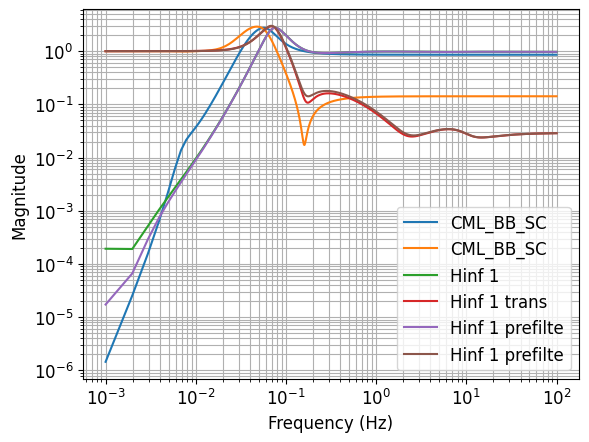

In [168]:

plt.loglog(f, abs(h_sc(1j*2*np.pi*f)), label="CML_BB_SC")
plt.loglog(f, abs((1-h_sc)(1j*2*np.pi*f)), label="CML_BB_SC")
plt.loglog(f, abs(h_sc_hinf1(1j*2*np.pi*f)), label="Hinf 1")
plt.loglog(f, abs(h_trans_hinf1(1j*2*np.pi*f)), label="Hinf 1 trans")
plt.loglog(f, abs(h_sc_hinf1_prefilt(1j*2*np.pi*f)), label="Hinf 1 prefilte")
plt.loglog(f, abs(h_trans_hinf1_prefilt(1j*2*np.pi*f)), label="Hinf 1 prefilte")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend(loc=0)
plt.grid(which="both")
# plt.loglog(f, abs((1-h_sc)(1j*2*np.pi*f)), "--")
# plt.loglog(f, abs((h1)(1j*2*np.pi*f)), "--")

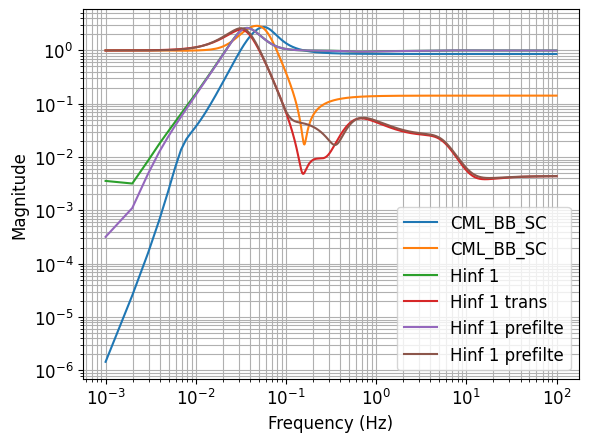

In [130]:

plt.loglog(f, abs(h_sc(1j*2*np.pi*f)), label="CML_BB_SC")
plt.loglog(f, abs((1-h_sc)(1j*2*np.pi*f)), label="CML_BB_SC")
plt.loglog(f, abs(h_sc_hinf4(1j*2*np.pi*f)), label="Hinf 1")
plt.loglog(f, abs(h_trans_hinf4(1j*2*np.pi*f)), label="Hinf 1 trans")
plt.loglog(f, abs(h_sc_hinf4_prefilt(1j*2*np.pi*f)), label="Hinf 1 prefilte")
plt.loglog(f, abs(h_trans_hinf4_prefilt(1j*2*np.pi*f)), label="Hinf 1 prefilte")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend(loc=0)
plt.grid(which="both")
# plt.loglog(f, abs((1-h_sc)(1j*2*np.pi*f)), "--")
# plt.loglog(f, abs((h1)(1j*2*np.pi*f)), "--")

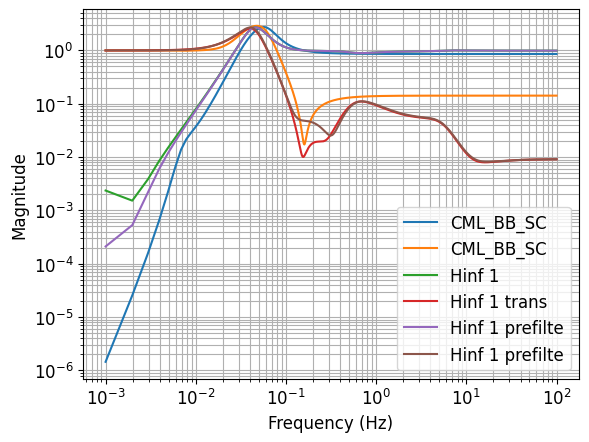

In [276]:

plt.loglog(f, abs(h_sc(1j*2*np.pi*f)), label="CML_BB_SC")
plt.loglog(f, abs((1-h_sc)(1j*2*np.pi*f)), label="CML_BB_SC")
plt.loglog(f, abs(h_sc_hinf4_2(1j*2*np.pi*f)), label="Hinf 1")
plt.loglog(f, abs(h_trans_hinf4_2(1j*2*np.pi*f)), label="Hinf 1 trans")
plt.loglog(f, abs(h_sc_hinf4_2_prefilt(1j*2*np.pi*f)), label="Hinf 1 prefilte")
plt.loglog(f, abs(h_trans_hinf4_2_prefilt(1j*2*np.pi*f)), label="Hinf 1 prefilte")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend(loc=0)
plt.grid(which="both")

In [279]:
n_seis_filtered_hinf1 = abs(h_sc_hinf1(1j*2*np.pi*f)) * n_seis1(f)
xg_filtered_hinf1 = abs((1-h_sc_hinf1)(1j*2*np.pi*f)) * xg1

n_seis_filtered_hinf4 = abs(h_sc_hinf4_prefilt(1j*2*np.pi*f)) * n_seis4(f)
xg_filtered_hinf4 = abs((1-h_sc_hinf4_prefilt)(1j*2*np.pi*f)) * xg4

n_seis_filtered_hinf4_2 = abs(h_sc_hinf4_2_prefilt(1j*2*np.pi*f)) * n_seis4(f)
xg_filtered_hinf4_2 = abs((1-h_sc_hinf4_2_prefilt)(1j*2*np.pi*f)) * xg4

n_sc_hinf1 = kontrol.core.math.quad_sum(n_seis_filtered_hinf1, xg_filtered_hinf1)

n_sc_hinf4 = kontrol.core.math.quad_sum(n_seis_filtered_hinf4, xg_filtered_hinf4)
n_sc_hinf4_2 = kontrol.core.math.quad_sum(n_seis_filtered_hinf4_2, xg_filtered_hinf4_2)



n_seis_filtered_pad_hinf1 = abs(h_sc_hinf1(1j*2*np.pi*f_)) * n_seis1_pad
xg_filtered_pad_hinf1 = abs((1-h_sc_hinf1)(1j*2*np.pi*f_)) * abs(tf_xg1(1j*2*np.pi*f_))

n_seis_filtered_pad_hinf4 = abs(h_sc_hinf4_prefilt(1j*2*np.pi*f_)) * n_seis4_pad
xg_filtered_pad_hinf4 = abs((1-h_sc_hinf4_prefilt)(1j*2*np.pi*f_)) * abs(tf_xg4(1j*2*np.pi*f_))

n_seis_filtered_pad_hinf4_2 = abs(h_sc_hinf4_2_prefilt(1j*2*np.pi*f_)) * n_seis4_pad
xg_filtered_pad_hinf4_2 = abs((1-h_sc_hinf4_2_prefilt)(1j*2*np.pi*f_)) * abs(tf_xg4(1j*2*np.pi*f_))

n_sc_pad_hinf1 = kontrol.core.math.quad_sum(n_seis_filtered_pad_hinf1, xg_filtered_pad_hinf1)

n_sc_pad_hinf4 = kontrol.core.math.quad_sum(n_seis_filtered_pad_hinf4, xg_filtered_pad_hinf4)
n_sc_pad_hinf4_2 = kontrol.core.math.quad_sum(n_seis_filtered_pad_hinf4_2, xg_filtered_pad_hinf4_2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


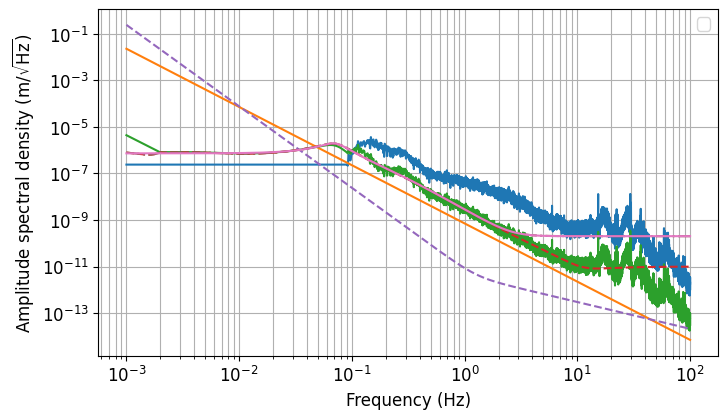

In [172]:
plt.figure(figsize=(8, 4.5))
plt.loglog(f, xg1)
plt.loglog(f, n_seis1(f))
# plt.loglog(f, n_sc1)
plt.loglog(f, n_sc_hinf1)
plt.loglog(f_, n_sc_pad_hinf1,"--")
plt.loglog(f, n_gs13(f), "--")
# plt.loglog(f, n_ade1(f), "--")
# plt.loglog(f_, n_rel_sc_hinf1, "-.")
plt.loglog(f_, n_rel_sc_hinf1, "-.")

plt.loglog(f_, abs(tf_rel_sc_hinf1(1j*2*np.pi*f_)), "-")
# plt.loglog(f_, n_gs13_pad)
# plt.loglog(f_, abs(3.16*tf_gs13(1j*2*np.pi*f_)))

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


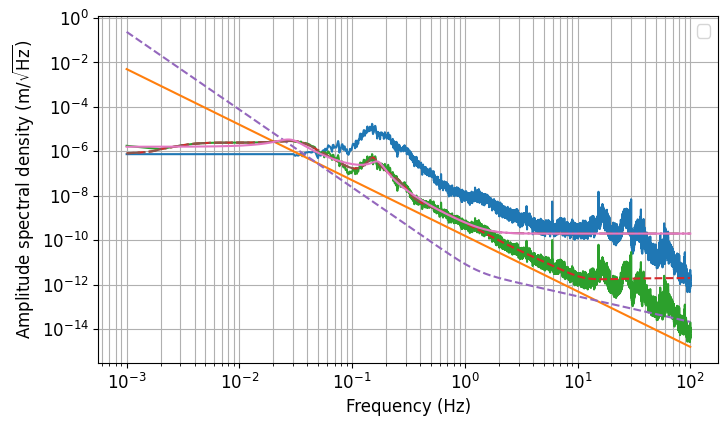

In [280]:
plt.figure(figsize=(8, 4.5))
plt.loglog(f, xg4)
plt.loglog(f, n_seis4(f))
# plt.loglog(f, n_sc1)
plt.loglog(f, n_sc_hinf4)
plt.loglog(f_, n_sc_pad_hinf4,"--")
plt.loglog(f, n_gs13(f), "--")
# plt.loglog(f, n_ade1(f), "--")
# plt.loglog(f_, n_rel_sc_hinf1, "-.")
plt.loglog(f_, n_rel_sc_hinf4, "-.")

plt.loglog(f_, abs(tf_rel_sc_hinf4(1j*2*np.pi*f_)), "-")
# plt.loglog(f_, n_gs13_pad)
# plt.loglog(f_, abs(3.16*tf_gs13(1j*2*np.pi*f_)))

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


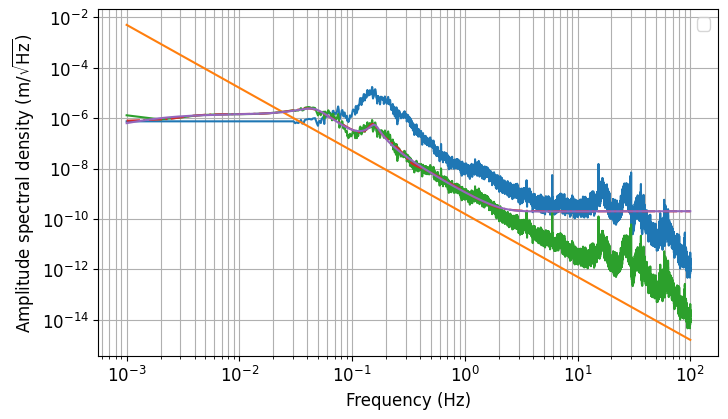

In [290]:
plt.figure(figsize=(8, 4.5))
plt.loglog(f, xg4)
plt.loglog(f, n_seis4(f))
# plt.loglog(f, n_sc1)
plt.loglog(f, n_sc_hinf4_2)
# plt.loglog(f_, n_sc_pad_hinf4_2,"--")
# plt.loglog(f, n_gs13(f), "--")
# plt.loglog(f, n_ade1(f), "--")
# plt.loglog(f_, n_rel_sc_hinf1, "-.")
plt.loglog(f_, n_rel_sc_hinf4_2, "-.")

plt.loglog(f_, abs(tf_rel_sc_hinf4_2(1j*2*np.pi*f_)), "-")
# plt.loglog(f_, n_gs13_pad)
# plt.loglog(f_, abs(3.16*tf_gs13(1j*2*np.pi*f_)))

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")

In [55]:
f1 = np.logspace(-1, 5, 1024)

In [282]:
n_rel_sc_hinf1 = kontrol.core.math.quad_sum(n_ade1(f_), n_sc_pad_hinf1)
n_rel_sc_hinf4 = kontrol.core.math.quad_sum(n_ade1(f_), n_sc_pad_hinf4)
n_rel_sc_hinf4_2 = kontrol.core.math.quad_sum(n_ade1(f_), n_sc_pad_hinf4_2)


n_gs13_pad = n_gs13(f_).copy()

f_upper_ = 4e1
n_gs13_pad[f_<3e-3] = n_gs13_pad[f_>=3e-3][0]
n_gs13_pad[f_>f_upper_] = n_gs13_pad[f_<=f_upper_][-1]

In [289]:
# tf_rel_sc_hinf1 = kontrol.curvefit.spectrum_fit(f_, n_rel_sc_hinf1, nzero=4, npole=4)
# tf_rel_sc_hinf4 = kontrol.curvefit.spectrum_fit(f_, n_rel_sc_hinf4, nzero=4, npole=4)
# tf_rel_sc_hinf4_2 = kontrol.curvefit.spectrum_fit(f_, n_rel_sc_hinf4_2, nzero=6, npole=6)

In [77]:
# tf_gs13 = kontrol.curvefit.spectrum_fit(f_, n_gs13_pad, nzero=4, npole=4)

In [220]:
comp2 = kontrol.ComplementaryFilter()
comp2.noise2 = tf_rel_sc_hinf1
comp2.noise1 = tf_gs13
comp2.weight2 = 1/tf_gs13
comp2.weight1 = 1/tf_rel_sc_hinf1
comp2.h2synthesis()

h2_hinf1, h1_hinf1 = comp2.hinfsynthesis()

In [228]:
# h1_hinf1.save("h1_hinf_20240222.pkl")

In [229]:
# h2_hinf1.save("h2_hinf_20240222.pkl")

In [268]:
comp2 = kontrol.ComplementaryFilter()
comp2.noise2 = tf_rel_sc_hinf4
comp2.noise1 = tf_gs13
comp2.weight2 = 1/tf_gs13
comp2.weight1 = 1/tf_rel_sc_hinf4
comp2.h2synthesis()

h2_hinf4, h1_hinf4 = comp2.hinfsynthesis()

In [291]:
comp2 = kontrol.ComplementaryFilter()
comp2.noise2 = tf_rel_sc_hinf4_2
comp2.noise1 = 3.16*tf_gs13
comp2.weight2 = 1/3.16/tf_gs13
comp2.weight1 = 1/tf_rel_sc_hinf4_2
comp2.h2synthesis()

h2_hinf4_2, h1_hinf4_2 = comp2.hinfsynthesis()

In [296]:
# h1_hinf4_2.save("h1_hinf_20240107_2.pkl")
# h2_hinf4_2.save("h2_hinf_20240107_2.pkl")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


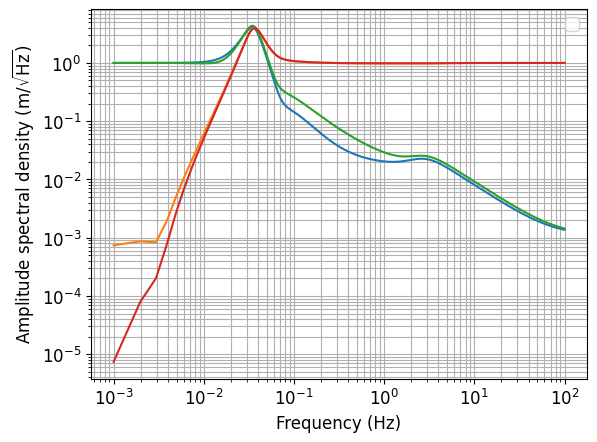

In [241]:
plt.loglog(f, abs(h1_hinf1(1j*2*np.pi*f)))
plt.loglog(f, abs(h2_hinf1(1j*2*np.pi*f)))
plt.loglog(f, abs(h1_hinf1_prefilt(1j*2*np.pi*f)))
plt.loglog(f, abs(h2_hinf1_prefilt(1j*2*np.pi*f)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


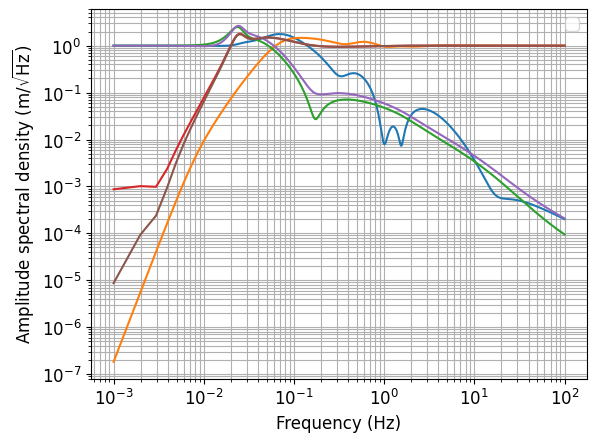

In [295]:
plt.loglog(f, abs(h1(1j*2*np.pi*f)))
plt.loglog(f, abs(h2(1j*2*np.pi*f)))

plt.loglog(f, abs(h1_hinf4(1j*2*np.pi*f)))
plt.loglog(f, abs(h2_hinf4(1j*2*np.pi*f)))
plt.loglog(f, abs(h1_hinf4_prefilt(1j*2*np.pi*f)))
plt.loglog(f, abs(h2_hinf4_prefilt(1j*2*np.pi*f)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


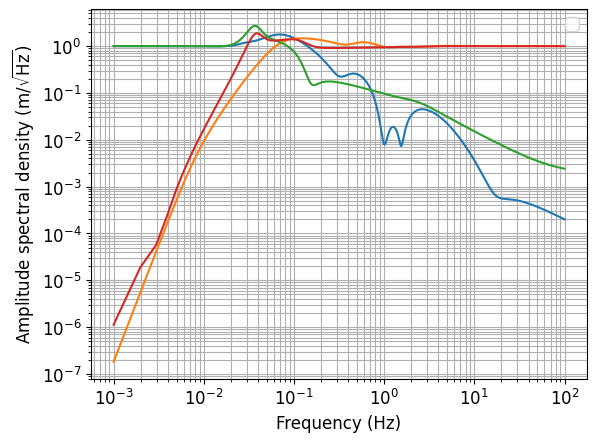

In [294]:
plt.loglog(f, abs(h1(1j*2*np.pi*f)))
plt.loglog(f, abs(h2(1j*2*np.pi*f)))

# plt.loglog(f, abs(h1_hinf4_2(1j*2*np.pi*f)))
# plt.loglog(f, abs(h2_hinf4_2(1j*2*np.pi*f)))
plt.loglog(f, abs(h1_hinf4_prefilt_2(1j*2*np.pi*f)))
plt.loglog(f, abs(h2_hinf4_prefilt_2(1j*2*np.pi*f)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")

In [293]:
n_rel_filtered_hinf1 = abs(h1_hinf1_prefilt(1j*2*np.pi*f_)) * n_rel_sc_hinf1
n_gs13_filtered_hinf1 = abs(h2_hinf1_prefilt(1j*2*np.pi*f_)) * n_gs13(f_)

n_rel_filtered_hinf4 = abs(h1_hinf4_prefilt(1j*2*np.pi*f_)) * n_rel_sc_hinf4
n_gs13_filtered_hinf4 = abs(h2_hinf4_prefilt(1j*2*np.pi*f_)) * n_gs13(f_)

n_rel_filtered_hinf4_2 = abs(h1_hinf4_prefilt_2(1j*2*np.pi*f_)) * n_rel_sc_hinf4_2
n_gs13_filtered_hinf4_2 = abs(h2_hinf4_prefilt_2(1j*2*np.pi*f_)) * n_gs13(f_)

n_super_hinf1 = kontrol.core.math.quad_sum(n_rel_filtered_hinf1, n_gs13_filtered_hinf1)
n_super_hinf4 = kontrol.core.math.quad_sum(n_rel_filtered_hinf4, n_gs13_filtered_hinf4)
n_super_hinf4_2 = kontrol.core.math.quad_sum(n_rel_filtered_hinf4_2, n_gs13_filtered_hinf4_2)


In [292]:
prefilt = (s**4/(s+(0.003*2*np.pi))**4)
h2_hinf1_prefilt = h2_hinf1 * prefilt
h1_hinf1_prefilt = 1 - h2_hinf1_prefilt

h2_hinf4_prefilt = h2_hinf4 * prefilt
h1_hinf4_prefilt = 1 - h2_hinf4_prefilt

h2_hinf4_prefilt_2 = h2_hinf4_2 * prefilt
h1_hinf4_prefilt_2 = 1 - h2_hinf4_prefilt_2

In [234]:
kontrol.TransferFunction(prefilt).save("h2_prefilter.pkl")